<a href="https://colab.research.google.com/github/cjs220/active_learning_ratio_estimation/blob/master/examples/multidim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# uncomment the code below to temporarily install active_learning_ratio_estimation from source
# if you do not do this, unless you already have it installed in this environment, this notebook will not run

import os, sys, tempfile, shutil
original_dir = os.getcwd()
REPO_NAME = 'active_learning_ratio_estimation'
BRANCH = 'master'
tempdir = tempfile.gettempdir()
os.chdir(tempdir)
if os.path.exists(REPO_NAME):
  print('Removing repo')
  shutil.rmtree(REPO_NAME)
print('Cloning repo')
os.system(f'git clone --single-branch --branch {BRANCH} https://github.com/cjs220/{REPO_NAME}.git')
sys.path.insert(0, os.path.join(tempdir, REPO_NAME))
os.chdir(original_dir)

Cloning repo


In [2]:
!pip install corner
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from corner import corner
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn import clone
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.datasets import make_sparse_spd_matrix

from active_learning_ratio_estimation.model import SinglyParameterizedRatioModel, DenseClassifier, FlipoutClassifier
from active_learning_ratio_estimation.dataset import ParamGrid, SinglyParameterizedRatioDataset

np.random.seed(0)
tf.random.set_seed(0)

  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11642 sha256=b5365566c00936df0fb57def9ad0440758362d1f78fe229078a471fdfbed8844
  Stored in directory: /root/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner


In [0]:
# matplotlib setup
%matplotlib inline

size=24
params = {
    'legend.fontsize': size*0.75,
    'figure.figsize': (10, 5),
    'axes.labelsize': size,
    'axes.titlesize': size,
    'xtick.labelsize': size * 0.75,
    'ytick.labelsize': size * 0.75,
    'font.family': 'sans-serif',
    'axes.titlepad': 12.5
}
plt.rcParams.update(params)

In [0]:
class MultiDimToyModel(tfd.TransformedDistribution):

    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

        # compose linear transform
        R = make_sparse_spd_matrix(5, alpha=0.5, random_state=7).astype(np.float32)
        self.R = R
        transform = tf.linalg.LinearOperatorFullMatrix(R)
        bijector = tfp.bijectors.AffineLinearOperator(scale=transform)

        super().__init__(distribution=self.z_distribution, bijector=bijector)

    @property
    def z_distribution(self):
        z_distribution = tfd.Blockwise([
            tfd.Normal(loc=self.alpha, scale=1),  # z1
            tfd.Normal(loc=self.beta, scale=3),  # z2
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
                components_distribution=tfd.Normal(
                    loc=[-2, 2],
                    scale=[1, 0.5]
                )
            ),  # z3
            tfd.Exponential(3),  # z4
            tfd.Exponential(0.5),  # z5
        ])
        return z_distribution

Instructions for updating:
`AffineLinearOperator` bijector is deprecated; please use `tfb.Shift(loc)(tfb.ScaleMatvecLinearOperator(...))`.


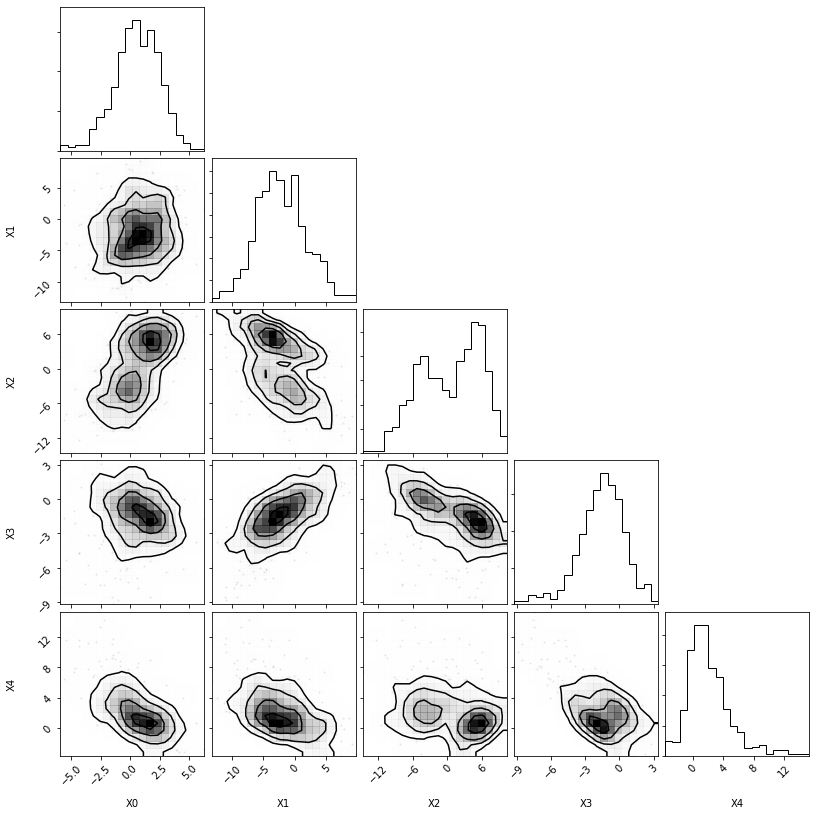

In [4]:
# Plot histograms / correlations of true distributions
true_alpha = 1
true_beta = -1
p_true = MultiDimToyModel(alpha=1, beta=-1)
X_true = p_true.sample(500)
fig = corner(X_true, bins=20, smooth=0.85, labels=["X0", "X1", "X2", "X3", "X4"])

In [5]:
# find exact maximum likelihood
var_alpha = tf.Variable(tf.constant(0, dtype=tf.float32))
var_beta = tf.Variable(tf.constant(0, dtype=tf.float32))
p_var = MultiDimToyModel(var_alpha, var_beta)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
n_iter = int(1e3)
nll = tf.function(lambda: -tf.keras.backend.sum(p_var.log_prob(X_true)))

for i in range(n_iter):
    optimizer.minimize(nll, [var_alpha, var_beta])

alpha_mle = var_alpha.numpy()
beta_mle = var_beta.numpy()
theta_mle = np.array([alpha_mle, beta_mle])
max_log_prob = p_var.log_prob(X_true)

print(f'\nExact MLE: alpha={alpha_mle:.2f}, beta={beta_mle:.2f}')


Exact MLE: alpha=0.99, beta=-1.19


In [0]:
# create dataset for fitting
param_grid_train = ParamGrid(bounds=[(-3, 3), (-3, 3)], num=30)
theta_0 = np.array([alpha_mle, beta_mle])
ds = SinglyParameterizedRatioDataset.from_simulator(
    simulator_func=MultiDimToyModel,
    theta_0=theta_0,
    theta_1_iterator=param_grid_train,
    n_samples_per_theta=int(1e3)
)

In [7]:
# hyperparams
epochs = 1
patience = 10
validation_split = 0.1
n_hidden = (30, 30)

# regular model
regular_estimator = DenseClassifier(
    n_hidden=n_hidden,
    activation='tanh',
    epochs=epochs,
    patience=patience,
    validation_split=validation_split
)
regular_model = SinglyParameterizedRatioModel(estimator=regular_estimator, calibration_method=None)

# bayesian model
bayesian_estimator = FlipoutClassifier(
    n_hidden=n_hidden,
    activation='relu',
    epochs=epochs,
    patience=patience,
    validation_split=validation_split
)
bayesian_model = SinglyParameterizedRatioModel(estimator=bayesian_estimator, calibration_method=None)

# fit models
regular_model.fit(ds)
bayesian_model.fit(ds)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

50625/50625 - 63s - loss: 0.4046 - accuracy: 0.7935 - val_loss: 0.3964 - val_accuracy: 0.7987
Instructions for updating:
Please use `layer.add_weight` method instead.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64

In [10]:
# predict log-likelihood contours
num_plot = 15
alpha_bounds = (0.75, 1.25) 
beta_bounds = (-2, 0)
plot_grid = ParamGrid(bounds=[alpha_bounds, beta_bounds], num=num_plot)
Alphas, Betas = plot_grid.meshgrid()

regular_pred_contours, regular_mle = regular_model.nllr_param_scan_with_calibration(
    x=X_true,
    param_grid=plot_grid,
    n_samples_per_theta=int(1e4),
    simulator_func=MultiDimToyModel,
)
bayes_pred_contours, bayes_mle = bayesian_model.nllr_param_scan(x=X_true, param_grid=plot_grid)

contours = {
    'Regular': regular_pred_contours,
    'Bayesian': bayes_pred_contours
}
mles = {
    'Regular': regular_mle,
    'Bayesian': bayes_mle
}


Calculating negative log-likelihood across parameter grid, calibrating at each point:
:   0%|          | 0/225 [00:00<?, ?it/s]
Calculating negative log-likelihood across parameter grid, calibrating at each point:
:   0%|          | 1/225 [00:00<02:45,  1.35it/s]
Calculating negative log-likelihood across parameter grid, calibrating at each point:
:   1%|          | 2/225 [00:01<02:41,  1.38it/s]
Calculating negative log-likelihood across parameter grid, calibrating at each point:
:   1%|▏         | 3/225 [00:02<02:39,  1.39it/s]
Calculating negative log-likelihood across parameter grid, calibrating at each point:
:   2%|▏         | 4/225 [00:02<02:38,  1.39it/s]
Calculating negative log-likelihood across parameter grid, calibrating at each point:
:   2%|▏         | 5/225 [00:03<02:36,  1.40it/s]
Calculating negative log-likelihood across parameter grid, calibrating at each point:
:   3%|▎         | 6/225 [00:04<02:35,  1.41it/s]
Calculating negative log-likelihood across parameter gr

NameError: ignored

In [11]:
# Calculate contours of exact negative log likelihood ratio
@tf.function
def nllr_exact(alpha, beta, X):
    p_theta = MultiDimToyModel(alpha=alpha, beta=beta)
    return -tf.keras.backend.sum((p_theta.log_prob(X) - max_log_prob))


exact_contours = np.zeros_like(Alphas)
for i in range(num_plot):
    for j in range(num_plot):
        alpha = tf.constant(Alphas[i, j])
        beta = tf.constant(Betas[i, j])
        nllr = nllr_exact(alpha, beta, X_true)
        exact_contours[i, j] = nllr

contours['Exact'] = exact_contours

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


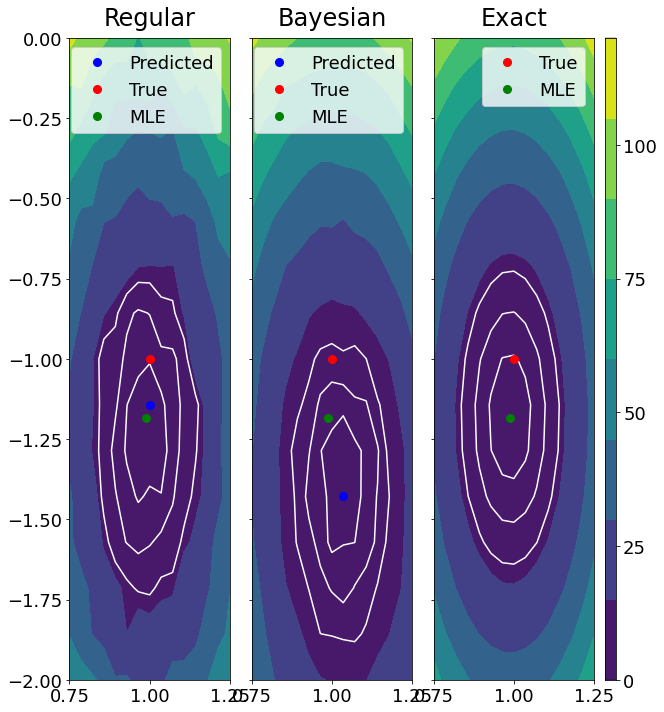

In [38]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(20, 10))

grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(1,len(contours)),
    axes_pad=0.3,
    share_all=True,
    cbar_location="right",
    cbar_mode="single",
    cbar_size="7%",
    cbar_pad=0.15,
)

for ax, contour_name in zip(grid, contours):
    contour = 2*contours[contour_name]

    if contour_name != 'Exact':
        contour = contour - contour.min()
        alpha_min, beta_min = mles[contour_name]
        ax.plot([alpha_min], [beta_min], 'bo', markersize=8, label='Predicted')
    
    im = ax.contourf(*plot_grid.meshgrid(), contour)
    ax.contour(
        *plot_grid.meshgrid(),
        contour,
        colors=['w'],
        levels=[chi2.ppf(0.683, df=2),
                chi2.ppf(0.9545, df=2),
                chi2.ppf(0.9973, df=2)]
    )
    ax.plot([true_alpha], [true_beta], "ro", markersize=8, label='True')
    ax.plot([alpha_mle], [beta_mle], "go", markersize=8, label='MLE')
    ax.legend()
    ax.set_title(contour_name)

ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.tight_layout()
plt.show()

{'Brier Score': {'Model': 0.12667043034541328}, 'F1 Score': {'Model': 0.8160804020100503}, 'Expected Calibration Error': {'Model': 0.021521656}}


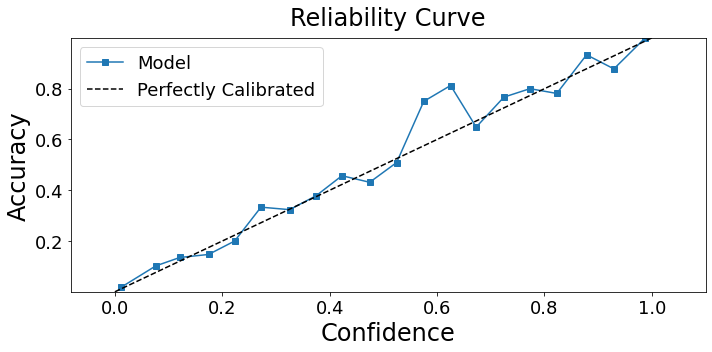

In [31]:
from active_learning_ratio_estimation.model.validation import plot_calibration
calibration_curves, scores = plot_calibration(bayesian_model, dataset=ds, n_data=int(1e3), n_bins=20)
print(scores)
plt.show()

In [0]:
from mpl_toolkits.axes_grid1 import ImageGrid

a, b = [np.linspace(0, 1, 1001)]*2
A, B = np.meshgrid(a, b)
C = A**2 + B**2
fig = plt.figure(figsize=(9.75, 3))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
for ax in grid:
    im = ax.contourf(A, B, C)
    ax.plot([0.5], [0.5], 'bo', label='A point')

ax.cax.colorbar(im)
ax.cax.toggle_label(True)
ax.legend()
plt.tight_layout()
plt.show()